In [1]:
!pip install torch
!pip install torch_geometric
!pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=f53cda43c50a500cb442902685af5cba6142164ff4b54745ee25fe140b35ab81
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch_geometric
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 43.6 MB/s eta 0:00:00


In [2]:
%matplotlib inline

In [3]:
!pip install snap-stanford

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 21.0 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import snap
import pandas as pd
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl.data
from dgl.nn import SAGEConv
import dgl.function as fn


graph_path = "/content/drive/MyDrive/ICPC/RedditHyperlinks.tsv"
G5 = snap.LoadEdgeList(snap.TNGraph,graph_path , 0, 1)




DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [6]:
df = pd.read_csv(graph_path, sep='\t')


In [7]:
len(list(set(df["SOURCE_SUBREDDIT"])) + list(set(df["TARGET_SUBREDDIT"]))), len(set(df["SOURCE_SUBREDDIT"])), len(set(df["TARGET_SUBREDDIT"]))

(4488, 2448, 2040)

In [8]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch

In [10]:
#@title Default title text
import pickle
from tqdm import tqdm
uniq_sreddits = list(set(df["SOURCE_SUBREDDIT"])) + list(set(df["TARGET_SUBREDDIT"]))
subreddit_stats = {i : {} for i, x in enumerate(uniq_sreddits) }
edge_indices = []

def gather_node_edge_statistics(df):
  for i, row in tqdm(df.iterrows()):
    SOURCE_SUBREDDIT = uniq_sreddits.index(row[0])
    TARGET_SUBREDDIT = uniq_sreddits.index(row[1])
    edge_indices.append([SOURCE_SUBREDDIT, TARGET_SUBREDDIT])
    # POST_ID          = row[2]
    # TIMESTAMP        = row[3]
    POST_LABEL       = row[4]
    POST_PROPERTIES  = row[5].split(",")

    # we are primarily interested in these averages:
    #8. Number of words
    #43. LIWC_Swear
    #19. Positive sentiment calculated by VADER
    #20. Negative sentiment calculated by VADER
    #21. Compound sentiment calculated by VADER
    #82. LIWC_Death
    #11. Average word length
    # assert len(POST_PROPERTIES) == 86
    if(len(POST_PROPERTIES) != 86):
      print(f"{len(POST_PROPERTIES)=}")
    else:
      nwords = float(POST_PROPERTIES[8-1])
      swear_sentiment = float(POST_PROPERTIES[43 -1])
      positivity = float(POST_PROPERTIES[19 -1])
      negativity = float(POST_PROPERTIES[20 -1])
      compound = float(POST_PROPERTIES[21 -1])
      avg_word_length = float(POST_PROPERTIES[11 - 1])
      # print(f"{POST_PROPERTIES=}")

      # print(f"{SOURCE_SUBREDDIT=}")
      # print(f"{TARGET_SUBREDDIT=}")
      # print(f"{POST_PROPERTIES[8-1]=}")
      # print(f"{type(subreddit_stats[SOURCE_SUBREDDIT])=}")
      # print(f"{type(subreddit_stats[SOURCE_SUBREDDIT])=}")
      if(subreddit_stats[SOURCE_SUBREDDIT] == {}):
        subreddit_stats[SOURCE_SUBREDDIT] = {
            "avg_words" : [nwords],
            "avg_swear_sentiment" : [swear_sentiment],
            "avg_positivity" : [positivity],
            "avg_negativity" : [negativity],
            "avg_compound" : [compound],
            "avg_word_length" : [avg_word_length],
            "sent_posts" : 1,
            "received_posts" : 0
        }
      else: 
        subreddit_stats[SOURCE_SUBREDDIT]["avg_words"].append(nwords)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_swear_sentiment"].append(swear_sentiment)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_positivity"].append(positivity)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_negativity"].append(negativity)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_compound"].append(compound)
        subreddit_stats[SOURCE_SUBREDDIT]["avg_word_length"].append(avg_word_length)
        subreddit_stats[SOURCE_SUBREDDIT]["sent_posts"]+=1

      if(subreddit_stats[TARGET_SUBREDDIT] == {}):
        subreddit_stats[TARGET_SUBREDDIT] = {
          "avg_words" : [0],
          "avg_swear_sentiment" : [0],
          "avg_positivity" : [0],
          "avg_negativity" : [0],
          "avg_compound" : [0],
          "avg_word_length" : [0],
          "sent_posts" : 0,
          "received_posts" : 1
      }
      else:
        subreddit_stats[TARGET_SUBREDDIT]["received_posts"]+=1

    

# node_stats = []
# get node statistics
gather_node_edge_statistics(df)
edge_indices = torch.tensor(edge_indices)

7798it [00:01, 4183.20it/s]


len(POST_PROPERTIES)=33


In [11]:
edge_indices.max()

tensor(4481)

In [12]:
import torch

In [13]:
#@title Default title text
import numpy as np
for i in subreddit_stats.keys():
  if(subreddit_stats[i] != {}):
    # print(f"{subreddit_stats[i]=}")
    # print(f"{type(subreddit_stats[i]['avg_words'])=}")
    # print(f"{subreddit_stats[i]['avg_words']=}")
    subreddit_stats[i]["avg_words"] = np.average(subreddit_stats[i]["avg_words"])
    subreddit_stats[i]["avg_swear_sentiment"] = np.average(subreddit_stats[i]["avg_swear_sentiment"])
    subreddit_stats[i]["avg_positivity"] = np.average(subreddit_stats[i]["avg_positivity"])
    subreddit_stats[i]["avg_negativity"] = np.average(subreddit_stats[i]["avg_negativity"])
    subreddit_stats[i]["avg_compound"] = np.average(subreddit_stats[i]["avg_compound"])
    subreddit_stats[i]["avg_word_length"] = np.average(subreddit_stats[i]["avg_word_length"])


with open("/content/drive/MyDrive/ICPC/subreddit_stats.pkl", "wb")  as f:
  pickle.dump(subreddit_stats, f)

In [14]:
#@title Default title text
node_stats_list = []
def stats_dict_2_tensor(subreddit_stats):
  _node_stats_list = []
  for i in subreddit_stats.keys():
    _node_stat_list = []
    # print(f"{subreddit_stats[i]=}")
    if(subreddit_stats[i] != {}):
      _node_stat_list.append(subreddit_stats[i]['avg_words'])
      _node_stat_list.append(subreddit_stats[i]['avg_swear_sentiment'])
      _node_stat_list.append(subreddit_stats[i]['avg_positivity'])
      _node_stat_list.append(subreddit_stats[i]['avg_negativity'])
      _node_stat_list.append(subreddit_stats[i]['avg_compound'])
      _node_stat_list.append(subreddit_stats[i]['avg_word_length'])
      _node_stat_list.append(subreddit_stats[i]['sent_posts'])
      _node_stat_list.append(subreddit_stats[i]['received_posts'])
      _node_stats_list.append(_node_stat_list)
  return torch.tensor(_node_stats_list)
node_stats_list = stats_dict_2_tensor(subreddit_stats)

In [15]:
edge_indices, node_stats_list.shape

(tensor([[ 772,  585],
         [ 581, 2040],
         [2302, 4095],
         ...,
         [2087, 1889],
         [1387, 1691],
         [ 713, 3772]]),
 torch.Size([3501, 8]))

In [16]:
# get rid of entries in the edge_index that reference nodes beyond the nodes in stats_list
pruned_edge_indices = [ x for x in edge_indices if x[0] < node_stats_list.shape[0] and x[1] < node_stats_list.shape[0]  ]
pruned_edge_indices = torch.stack(pruned_edge_indices)
pruned_edge_indices.shape, pruned_edge_indices.max()
edge_indices = pruned_edge_indices

In [17]:
# 2,3,4,6,7
# correspond to positivity, negativity, compound (negativity and positivity combined), sent, and received respectively
most_negative_node = np.argmin(node_stats_list[:, 4])
most_positive_node = np.argmax(node_stats_list[:, 4])
most_active_node = np.argmax(node_stats_list[:, 6])
most_sweary_node = np.argmax(node_stats_list[: , 1])

# subreddit_stats[most_negative_node],subreddit_stats[most_positive_node], subreddit_stats[most_active_node], subreddit_stats[most_sweary_node]


In [18]:
from torch_geometric.datasets import Planetoid
# Load data
dataset = Planetoid(root='./data/cora', name='cora')
data = dataset[0]
data

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [19]:
data.num_node_features, dataset.num_classes

(1433, 7)

In [20]:

import random 

def gen_train_mask( num_nodes : int, n : int) -> torch.tensor:
  rand_indices = [True] * num_nodes
  for i in range(n):
    num = random.randint(0, num_nodes - 1)
    rand_indices[num] = False
  return rand_indices
  
gen_train_mask(15, 2)

[True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True]

In [21]:
from torch_geometric.data import Data

train_mask = gen_train_mask(node_stats_list.shape[0], round(0.3 * node_stats_list.shape[0]))
# train_mask = gen_train_mask(edge_indices.shape[0], round(0.60 * edge_indices.shape[0]))
train_mask = torch.tensor(train_mask)
x = torch.tensor(node_stats_list)
x = x.float()
edge_indices = edge_indices.int()
print(f"{type(x)=}")
print(f"{edge_indices.shape=}")
dataset = Data(x =x , edge_index = edge_indices.T, train_mask =train_mask  )


type(x)=<class 'torch.Tensor'>
edge_indices.shape=torch.Size([6503, 2])


<ipython-input-21-ab3782da0f76>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(node_stats_list)


In [22]:
dataset.x.shape, dataset.edge_index.shape

(torch.Size([3501, 8]), torch.Size([2, 6503]))

In [23]:
dataset.x[dataset.train_mask][0],  dataset.x[~dataset.train_mask][0]

num_nodes = dataset.x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:500] = 1

# Use the train_mask to get the subset of nodes and edges
sub_data = dataset.x[train_mask]
sub_data.shape

torch.Size([500, 8])

In [24]:
dataset.edge_index[:, :].max()

tensor(3499, dtype=torch.int32)

In [25]:
# NEED TO MAKE IT SO THAT MAX ENTRY IN DATASET.X IS < len(uniq_sreddits)!!!!!
dataset.edge_index.shape, dataset.x.shape, len(uniq_sreddits)

(torch.Size([2, 6503]), torch.Size([3501, 8]), 4488)

In [26]:
dataset.num_features

8

In [27]:
num_train_nodes = round(dataset.edge_index.shape[1] * 0.8)
train_mask = torch.zeros(dataset.edge_index.shape[1], dtype=torch.bool)
train_mask[:num_train_nodes] = True
dataset = Data(x =x , edge_index = edge_indices.T, train_mask =train_mask  )

In [28]:
from torch_geometric.utils import negative_sampling

In [29]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv


In [30]:
# Set up the training and testing data
edge_index = edge_indices.T
total_indices = edge_indices.shape[0]
total_indices

alpha = 0.8
train_size = round((alpha) * total_indices)
test_size =  round( (1 - alpha) * total_indices )

In [31]:
total_indices, train_size, test_size, edge_index.shape

(6503, 5202, 1301, torch.Size([2, 6503]))

In [32]:



# subsample the training and test based off the positive edge_indices instead of the negative edge indices

neg_edge_index = negative_sampling(
        edge_index=edge_index,
        num_nodes=node_stats_list.shape[0],
        num_neg_samples=edge_index.shape[1]
    )


train_pos_edge_index = edge_index[:, :train_size] 
train_neg_edge_index = neg_edge_index[:, :train_size]


test_pos_edge_index = edge_index[:, train_size:]
test_neg_edge_index = neg_edge_index[:, train_size:]



In [33]:
train_neg_edge_index.shape, train_pos_edge_index.shape, test_pos_edge_index.shape, test_neg_edge_index.shape

(torch.Size([2, 5202]),
 torch.Size([2, 5202]),
 torch.Size([2, 1301]),
 torch.Size([2, 1301]))

In [34]:
train_pos_edge_index,train_neg_edge_index 

(tensor([[ 772,  581,  624,  ...,  210, 1830, 1389],
         [ 585, 2040, 2058,  ...,  999, 1602,  265]], dtype=torch.int32),
 tensor([[1450, 2752,   70,  ..., 1247,  265, 2392],
         [ 672,  886, 1469,  ..., 1909, 3076, 2461]]))

In [35]:
import torch.nn as nn

In [36]:
import torch_geometric as pyg
import torch
from torch import nn
import torch.nn.functional as F

class LinkPredictor(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(LinkPredictor, self).__init__()

        # Create linear layers
        self.lins = nn.ModuleList()
        self.lins.append(nn.Linear(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            layer = nn.Linear(hidden_channels, hidden_channels)
            torch.nn.init.xavier_uniform(layer.weight)  
            self.lins.append(layer)
        layer = nn.Linear(hidden_channels, out_channels)
        torch.nn.init.xavier_uniform(layer.weight)  
        self.lins.append(layer)

        self.dropout = dropout

    def reset_parameters(self):
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x_i, x_j):
        # x_i and x_j are both of shape (E, D)
        x = x_i * x_j
        for lin in self.lins[:-1]:
            x = lin(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.lins[-1](x)
        return torch.sigmoid(x)
    def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          module.weight.data.normal_(mean=0.0, std=1.0)
          if module.bias is not None:
              module.bias.data.zero_()


In [37]:
def train(link_predictor, batch_size, optimizer):
    link_predictor.train()

    train_losses = []
    n = 10
    for iedge in range(0, train_pos_edge_index.shape[1], n):
        # Run message passing on the inital node embeddings to get updated embeddings

        # Predict the class probabilities on the batch of positive edges using link_predictor
        pos_edge = train_pos_edge_index[:, iedge:iedge+n]  # (2, B)
        pos_pred = link_predictor(node_stats_list[pos_edge[0]], node_stats_list[pos_edge[1]])  # (B, )
        # print(f"{pos_pred.shape=}")
        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        neg_edge = train_neg_edge_index[:, iedge:iedge+n]  # (2, B)
        # print(f"{neg_edge.shape=}")
        neg_pred = link_predictor(node_stats_list[neg_edge[0]], node_stats_list[neg_edge[1]])  # (Ne,)
        # print(f"{neg_pred.shape=}")

        # if iedge%1000 == 0:
          # print(f"{pos_pred=}")
          # print(f"{neg_pred=}")
        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() -  torch.log(1 - neg_pred + 1e-15).mean()
        # print(f"{loss=}")

        # Backpropagate and update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # for param in link_predictor.parameters():
          # print(param.grad)
        train_losses.append(loss.item())
        # print(loss.item())
    return sum(train_losses) / len(train_losses)

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
node_stats_list = torch.tensor(node_stats_list).float().to(device)

<ipython-input-38-8cb65b2050cc>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node_stats_list = torch.tensor(node_stats_list).float().to(device)


In [39]:
node_stats_list.shape

torch.Size([3501, 8])

In [40]:
node_stats_list = torch.nn.functional.normalize(node_stats_list, p=2.0, dim = 1)

In [41]:
torch.norm(node_stats_list[0]), node_stats_list[0]

(tensor(1.0000),
 tensor([9.9450e-01, 0.0000e+00, 1.4824e-03, 9.3821e-04, 1.6888e-03, 1.0303e-01,
         1.8764e-02, 0.0000e+00]))

In [42]:
import tqdm
from tqdm import tqdm

In [52]:
# train_graph = torch.load('train.pt')
# val_graph = torch.load('val.pt')


optim_wd = 0.001
epochs = 50
hidden_dim = 150
dropout = 0.2
num_layers = 5
lr = 0.01
node_emb_dim = 1
batch_size = 10


# train_graph = train_graph.to(device)
# val_graph = val_graph.to(device)

# model = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, emb=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictor(node_stats_list.shape[1], hidden_dim, 1, num_layers + 1, dropout).to(device)
# pos_pred = link_predictor(node_emb[pos_edge[0]], node_emb[pos_edge[1]])  # (B, )
pred = link_predictor(node_stats_list[0], node_stats_list[100])

optimizer = torch.optim.Adam(
    link_predictor.parameters(),
    lr=lr, weight_decay=optim_wd
)

train_losses = []

for epoch in tqdm(range(epochs)):
  train_loss = train(
	link_predictor, 
	batch_size, 
	optimizer
  )
  print(f"{train_loss=}")
  train_losses.append(train_loss)

train_loss 




<ipython-input-36-b9b2c000608a>:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
<ipython-input-36-b9b2c000608a>:19: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(layer.weight)
  2%|▏         | 1/50 [00:02<02:06,  2.58s/it]

train_loss=1.2909268091598993


  4%|▍         | 2/50 [00:04<01:58,  2.48s/it]

train_loss=1.2826369100477324


  6%|▌         | 3/50 [00:09<02:41,  3.43s/it]

train_loss=1.2940018480203888


  8%|▊         | 4/50 [00:15<03:25,  4.47s/it]

train_loss=1.2772324445609167


 10%|█         | 5/50 [00:21<03:42,  4.95s/it]

train_loss=1.259100479150688


 12%|█▏        | 6/50 [00:28<04:03,  5.53s/it]

train_loss=1.2350078638135358


 14%|█▍        | 7/50 [00:34<04:05,  5.70s/it]

train_loss=1.2338356000448143


 16%|█▌        | 8/50 [00:41<04:15,  6.08s/it]

train_loss=1.2434869121452667


 18%|█▊        | 9/50 [00:46<04:02,  5.92s/it]

train_loss=1.2285422306371971


 20%|██        | 10/50 [00:52<03:58,  5.95s/it]

train_loss=1.2184693550194066


 22%|██▏       | 11/50 [00:58<03:55,  6.05s/it]

train_loss=1.2196769935155785


 24%|██▍       | 12/50 [01:04<03:48,  6.00s/it]

train_loss=1.220368150099683


 26%|██▌       | 13/50 [01:11<03:51,  6.25s/it]

train_loss=1.2302503030954532


 28%|██▊       | 14/50 [01:18<03:50,  6.41s/it]

train_loss=1.2481287626295767


 30%|███       | 15/50 [01:24<03:43,  6.39s/it]

train_loss=1.2326610606599906


 32%|███▏      | 16/50 [01:30<03:29,  6.15s/it]

train_loss=1.2558402277228928


 34%|███▍      | 17/50 [01:36<03:20,  6.07s/it]

train_loss=1.2244677019668404


 36%|███▌      | 18/50 [01:42<03:17,  6.19s/it]

train_loss=1.2339079136354223


 38%|███▊      | 19/50 [01:48<03:03,  5.94s/it]

train_loss=1.2278814148765609


 40%|████      | 20/50 [01:54<03:00,  6.02s/it]

train_loss=1.2167623411442177


 42%|████▏     | 21/50 [02:00<02:53,  5.98s/it]

train_loss=1.2290723894699522


 44%|████▍     | 22/50 [02:05<02:42,  5.81s/it]

train_loss=1.2352620348362913


 46%|████▌     | 23/50 [02:12<02:50,  6.30s/it]

train_loss=1.236996372350118


 48%|████▊     | 24/50 [02:18<02:36,  6.03s/it]

train_loss=1.2303333201243645


 50%|█████     | 25/50 [02:24<02:30,  6.01s/it]

train_loss=1.2200810794866932


 52%|█████▏    | 26/50 [02:30<02:24,  6.04s/it]

train_loss=1.2182868520037455


 54%|█████▍    | 27/50 [02:35<02:14,  5.85s/it]

train_loss=1.2138680491932523


 56%|█████▌    | 28/50 [02:42<02:15,  6.17s/it]

train_loss=1.2091342541398105


 58%|█████▊    | 29/50 [02:48<02:07,  6.07s/it]

train_loss=1.2249145285868142


 60%|██████    | 30/50 [02:54<01:57,  5.88s/it]

train_loss=1.2083200090448596


 62%|██████▏   | 31/50 [03:00<01:56,  6.11s/it]

train_loss=1.2362882863308327


 64%|██████▍   | 32/50 [03:05<01:45,  5.86s/it]

train_loss=1.216526841705454


 66%|██████▌   | 33/50 [03:12<01:40,  5.93s/it]

train_loss=1.2570651596887557


 68%|██████▊   | 34/50 [03:18<01:36,  6.05s/it]

train_loss=1.227836348044895


 70%|███████   | 35/50 [03:23<01:27,  5.82s/it]

train_loss=1.2154950499534607


 72%|███████▏  | 36/50 [03:30<01:23,  5.98s/it]

train_loss=1.228009893775215


 74%|███████▍  | 37/50 [03:35<01:16,  5.85s/it]

train_loss=1.2135415864311117


 76%|███████▌  | 38/50 [03:40<01:08,  5.72s/it]

train_loss=1.2151506137024188


 78%|███████▊  | 39/50 [03:49<01:10,  6.41s/it]

train_loss=1.214188146842876


 80%|████████  | 40/50 [03:55<01:03,  6.39s/it]

train_loss=1.2073297028120558


 82%|████████▏ | 41/50 [04:00<00:55,  6.11s/it]

train_loss=1.229364341943598


 84%|████████▍ | 42/50 [04:07<00:49,  6.25s/it]

train_loss=1.1949475626112631


 86%|████████▌ | 43/50 [04:12<00:41,  5.98s/it]

train_loss=1.2129512945200798


 88%|████████▊ | 44/50 [04:18<00:36,  6.02s/it]

train_loss=1.205761764076987


 90%|█████████ | 45/50 [04:25<00:30,  6.12s/it]

train_loss=1.2106688678150213


 92%|█████████▏| 46/50 [04:30<00:23,  5.91s/it]

train_loss=1.2187578427585668


 94%|█████████▍| 47/50 [04:37<00:18,  6.11s/it]

train_loss=1.2190593188188812


 96%|█████████▌| 48/50 [04:42<00:11,  5.88s/it]

train_loss=1.2038088577036208


 98%|█████████▊| 49/50 [04:48<00:05,  5.93s/it]

train_loss=1.2155286545030444


100%|██████████| 50/50 [04:54<00:00,  5.90s/it]

train_loss=1.2363824429072712


1.2363824429072712

In [53]:
test_pos_edge_index.shape

torch.Size([2, 1301])

In [54]:
test_pos_edge_index.shape, test_pos_edge_index[0, :]

(torch.Size([2, 1301]),
 tensor([ 258, 2320,   92,  ...,  735, 2087, 1387], dtype=torch.int32))

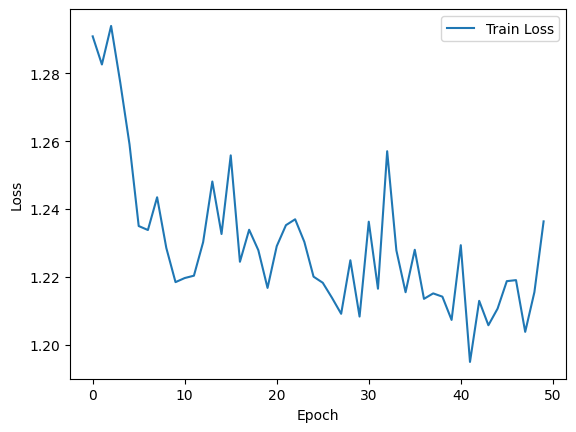

In [55]:
import matplotlib.pyplot as plt

epochs_plot = np.arange(0, epochs, 1)
plt.plot(epochs_plot, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [56]:
pos_preds = []
neg_preds = []

for iedge in range(0, test_pos_edge_index.shape[1], 1):
  pos_edge = test_pos_edge_index[:, iedge:iedge+1]  # (2, B)
  pos_pred = link_predictor(node_stats_list[pos_edge[0]], node_stats_list[pos_edge[1]])  # (B, )
  pos_preds.append(pos_pred)

  neg_edge = test_neg_edge_index[:, iedge:iedge+1]  # (2, B)
  neg_pred = link_predictor(node_stats_list[neg_edge[0]], node_stats_list[neg_edge[1]])  # (Ne,)
  neg_preds.append(neg_pred)

In [57]:
pos_preds = torch.tensor(pos_preds)
neg_preds = torch.tensor(neg_preds)

true_positives = (pos_preds>0.5).sum() 
false_negatives = (pos_preds<0.5).sum() 

true_negatives= (neg_preds<0.5).sum() 
false_positives = (neg_preds>0.5).sum() 
confusion_matrix = torch.tensor([  [true_positives,false_positives ] ,   [false_negatives, true_negatives]])

<Axes: >

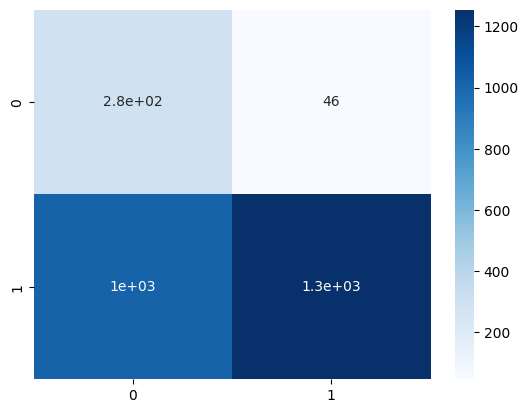

In [58]:
import seaborn as sns
sns.heatmap(confusion_matrix, annot=True, cmap='Blues')

In [59]:
accuracy= (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives )
print(f"{accuracy=}")

accuracy=tensor(0.5911)


<Axes: >

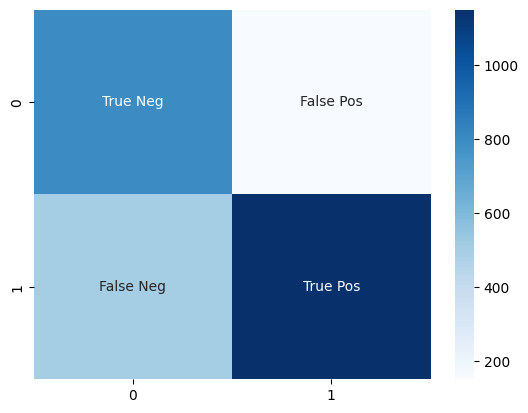

In [51]:
labels = ['True Neg','False Pos','False Neg','True Pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:

train_loss  

1.2941446313526639

In [ ]:
pred = link_predictor(node_stats_list[0], node_stats_list[00])
pred